In [67]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import os
import seaborn as sns
from tensorflow.keras.models import load_model
from matplotlib import cm, gridspec
from utils import get_data, normalize, predict
from custom_generator import DataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib as mpl
import matplotlib.patches as mpatches
import pingouin as pg

import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 27

plt.style.use('ggplot')

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

## Confusion Matrix for all TMs

In [2]:
def get_cfm_acc(X_it, y_true, model):
    y_pred = np.argmax(model.predict_generator(X_it), axis=1)
    acc = accuracy_score(y_true, y_pred)
    return confusion_matrix(y_true, y_pred, normalize='pred'), acc, y_pred

def viz_cfm(cfm, title, ax):
    ax.set_title(title)
    
    sns.heatmap(cfm, annot=True, fmt='.2g', cmap=cm.Blues, ax = ax, cbar=False)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['slow', 'medium', 'fast']); ax.yaxis.set_ticklabels(['slow', 'medium', 'fast']);

In [3]:
X_indexes = pd.read_csv("data/X_test_10.csv", header=None).values.flatten()
Y = np.load("data/Y_RT_10.npy")

y_true = Y[X_indexes - 1]

Y = to_categorical(Y)
data_dir = "data/RT_10_data/"
test_it = DataGenerator(data_dir, X_indexes, Y, target_shape=(500, 64), 
                        num_classes=3, batch_size=90, shuffle=False)

y_trues = np.tile(y_true, 10)

In [4]:
model_dir = "top_10_tm"
model_ids = ["TM-{}".format(id + 1) for id in range(10)]

cfm_dict = dict()
acc_dict = dict()
y_preds = []

for id in tqdm(model_ids):
    model_path = os.path.join(model_dir, "{}.h5".format(id))
    
    K.clear_session()
    
    model = load_model(model_path)
    cfm_dict[id], acc_dict[id], y_pred = get_cfm_acc(test_it, y_true, model)
    y_preds = np.append(y_preds, y_pred)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



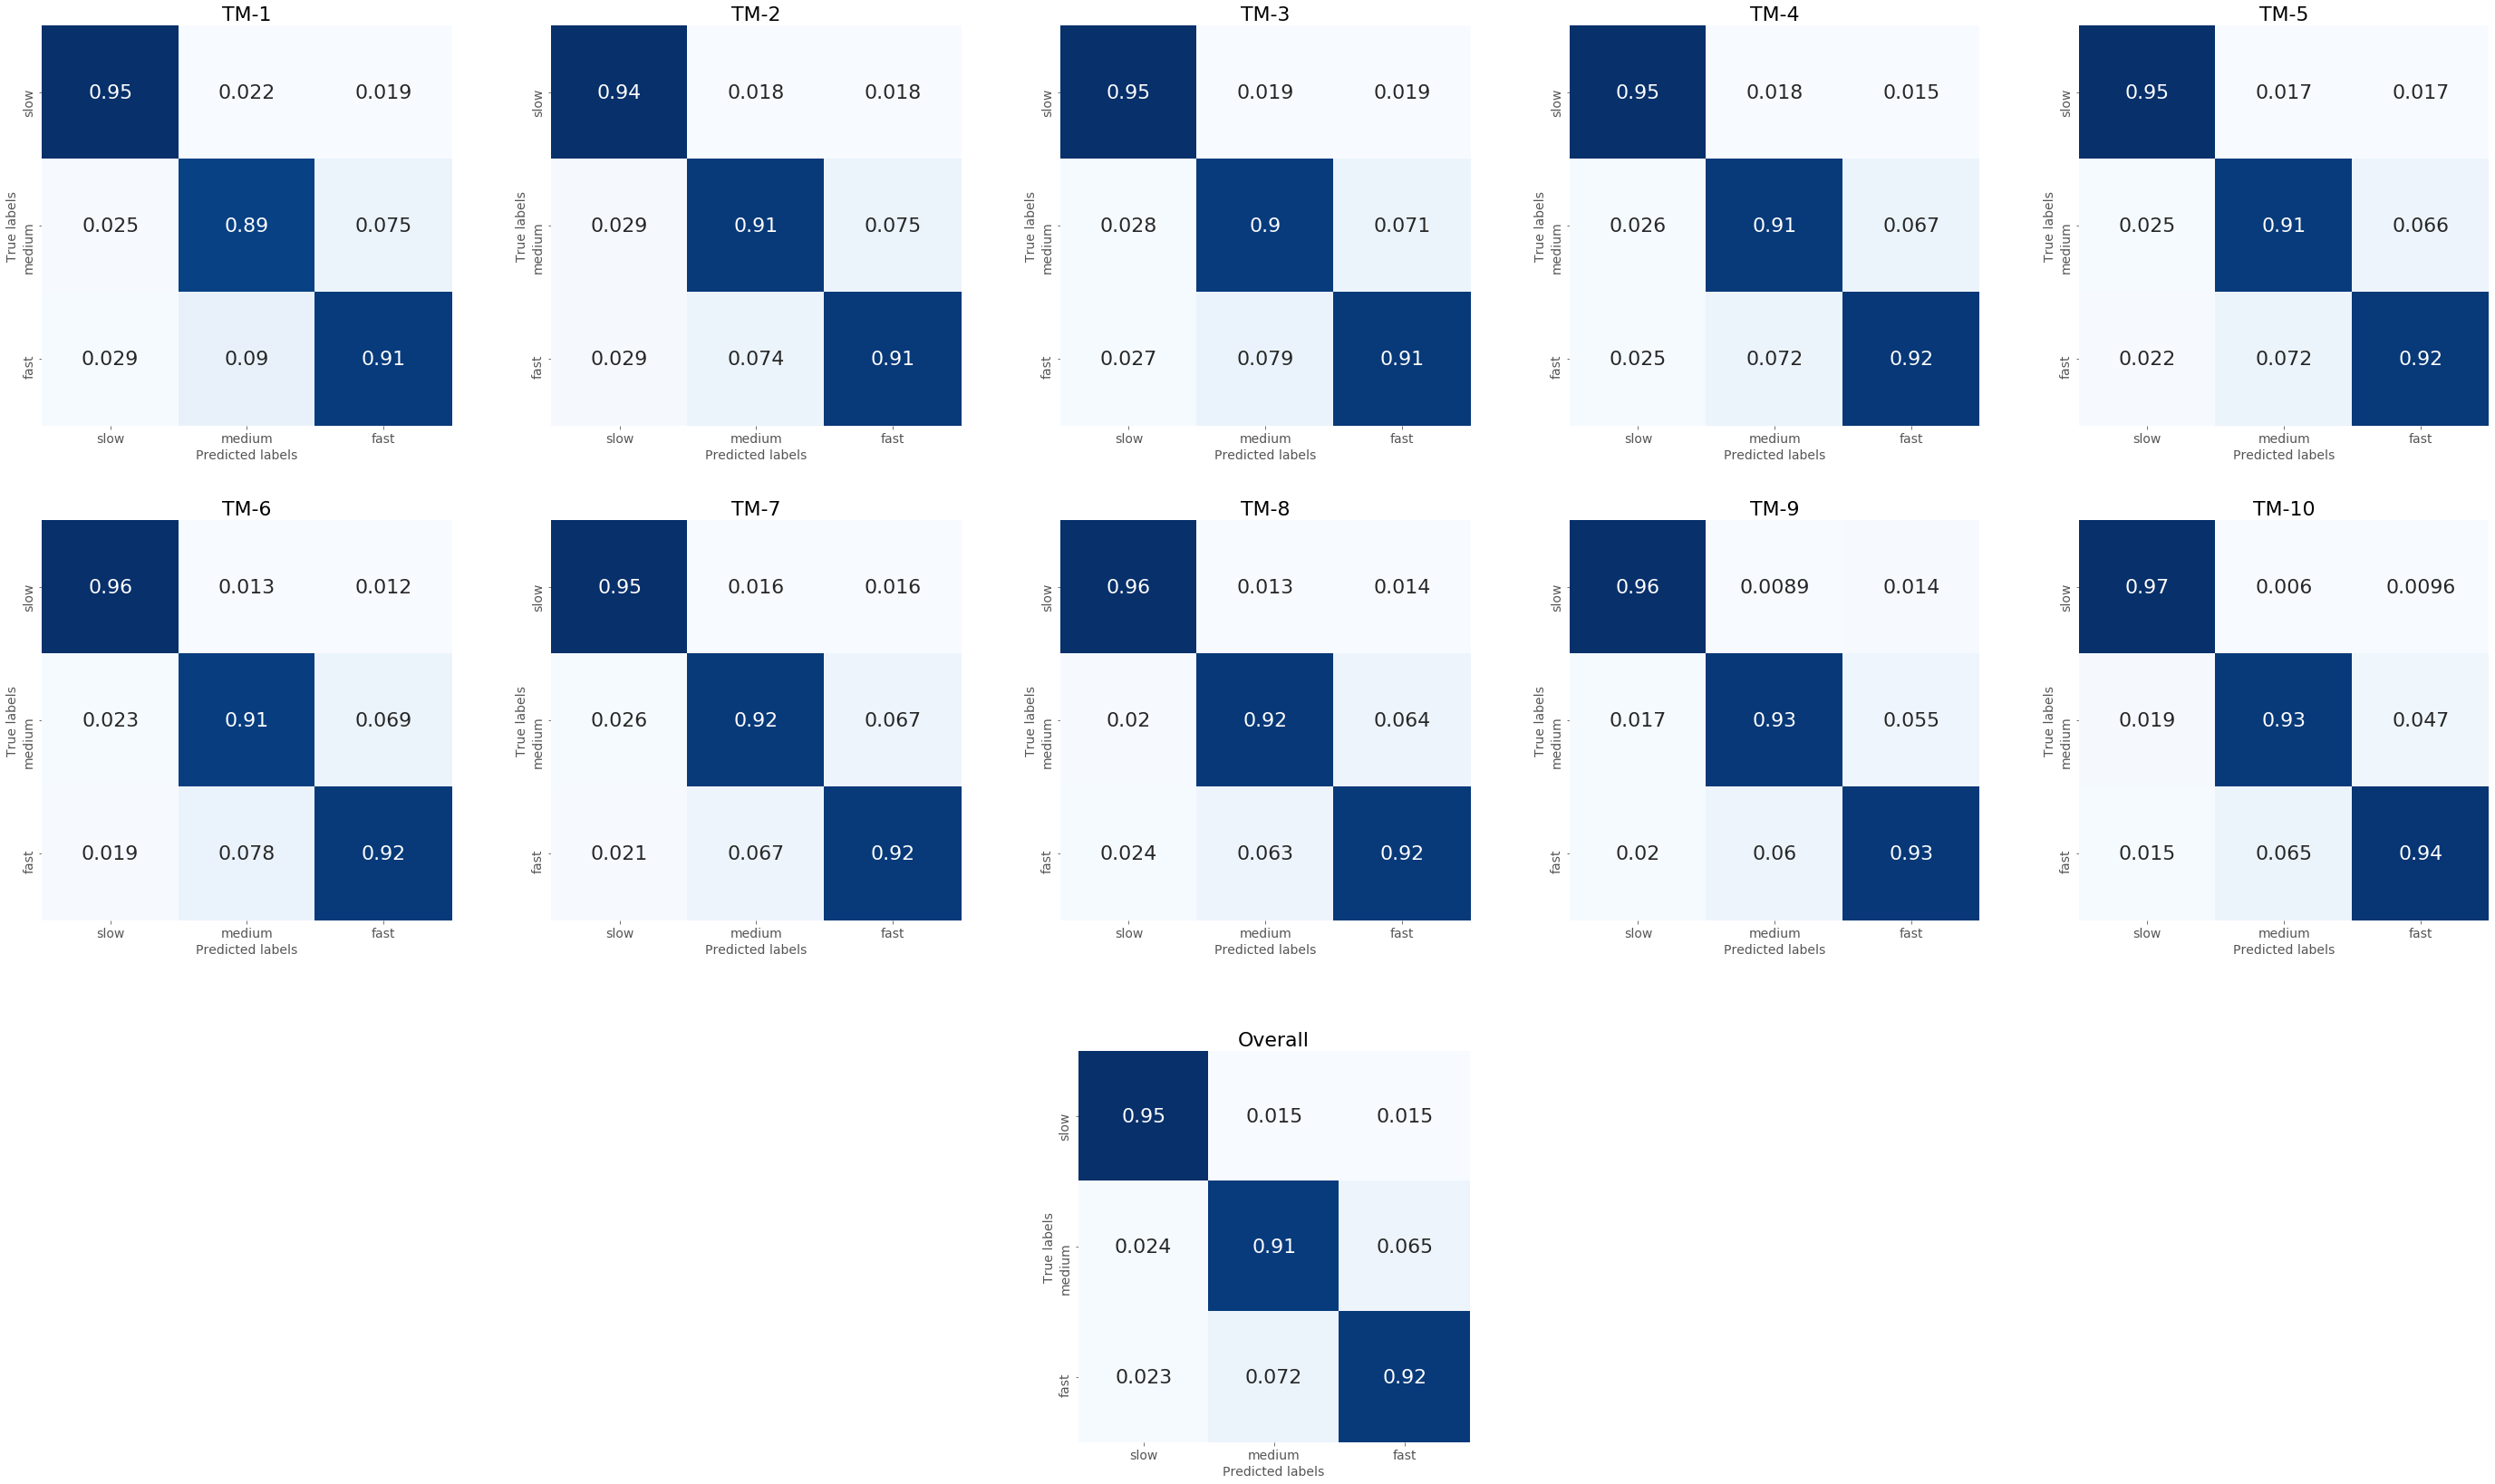

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(40, 20))
axes = axes.flatten()

for i,id in enumerate(cfm_dict):
    viz_cfm(cfm_dict[id], id, axes[i])
    
fig.tight_layout(pad=3.2)
overall_cfm = confusion_matrix(y_trues, y_preds, normalize='pred')

fig.subplots_adjust(bottom=0.25)
ax = fig.add_axes([0.435, -0.15, 0.15, 0.30])

viz_cfm(overall_cfm, "Overall", ax)

## Visualize Spatial Saliency for all TMs

In [8]:
model_smaps = dict()

n_slow = 0
n_med = 0
n_fast = 0
overall_tm_smaps = 0

for i,id in tqdm(enumerate(model_ids)):
    
    slow_sm = np.load("saliency_maps/slow/{}.npy".format(id))
    med_sm = np.load("saliency_maps/med/{}.npy".format(id))
    fast_sm = np.load("saliency_maps/fast/{}.npy".format(id))
    
    n_slow = len(slow_sm)
    n_med = len(med_sm)
    n_fast = len(fast_sm)
    
    smaps = np.vstack((slow_sm, med_sm, fast_sm))
    model_smaps[id] = normalize(np.mean(smaps, axis=0))
    
    overall_tm_smaps = overall_tm_smaps + acc_dict[id] * smaps
    del slow_sm, med_sm, fast_sm, smaps

In [96]:
def viz_avg_smaps(smap, T, title, plt):
    im = plt.imshow(smap, cmap='plasma')
    plt.set_title(title)
    plt.get_ypltis().set_ticks([])
    plt.set_ylabel("GradCAM")
    t = np.array(list(range(0, 500, 50)))
    t = np.append(t, 499)
    plt.get_xpltis().set_ticks(t)
    
    labels = ["{} ms".format(T[i]) for i in t]
    plt.get_xpltis().set_ticklabels(labels)
    
def viz_temporal_saliency(sc, T, title, rt_class, gs):
    
    sc_mean = dict()
    
    for i,cls in enumerate(rt_class):       
        sc_mean[cls] = np.mean(sc[cls], axis=0)
    
    sc_mean = scale_sc(sc_mean)
    
    time_ticks = np.arange(0,9,1)
    time_labels = ['-200-0']
    time_labels.extend(['{}-{}'.format(T[i], T[i+50]) for i in range(100, 500, 50) if i + 50 < 500])
    time_labels.append('700-800')
    
    colors = ["#00695C","#283593", "#D84315"]
    width = 0.15
    plt.subplot(gs)
    plt.title(title)
    plt.xticks(time_ticks, time_labels)
    plt.xlabel('Time (ms)')
    plt.ylim([0,1.1])
    plt.yticks(np.arange(0.2, 1.1, 0.2))
    for i,cls in enumerate(rt_class):       
        plt.scatter(time_ticks, sc_mean[cls], s=500, label=cls, marker='D', c=colors[i])
        plt.plot(time_ticks, sc_mean[cls], linewidth=10, c=colors[i], alpha=0.1)
        
def scale_sc(model_dict):
    cls_arrs = model_dict.values()
    max = 0
    min = 0
    for arr in cls_arrs:
        t_max = arr.max()
        t_min = arr.min()
        
        if t_max > max:
            max = t_max
        if t_min < min:
            min = t_min
            
    scaler = lambda x: ((x - min) / (max - min))
    
    for rt_class in model_dict:
        model_dict[rt_class] = scaler(model_dict[rt_class])
        
    return model_dict
def get_overall_sc(model_sc, acc_dict):
    overall_tm_sc = {'slow': 0, 'med': 0, 'fast': 0}
    for id in model_sc:
        model_sc_rt = model_sc[id]
        for rt_class in model_sc_rt:
            overall_tm_sc[rt_class] = overall_tm_sc[rt_class] + acc_dict[id] * model_sc_rt[rt_class]
    for rt_class in overall_tm_sc:
        overall_tm_sc[rt_class] = overall_tm_sc[rt_class] / 10
    return scale_sc(overall_tm_sc)

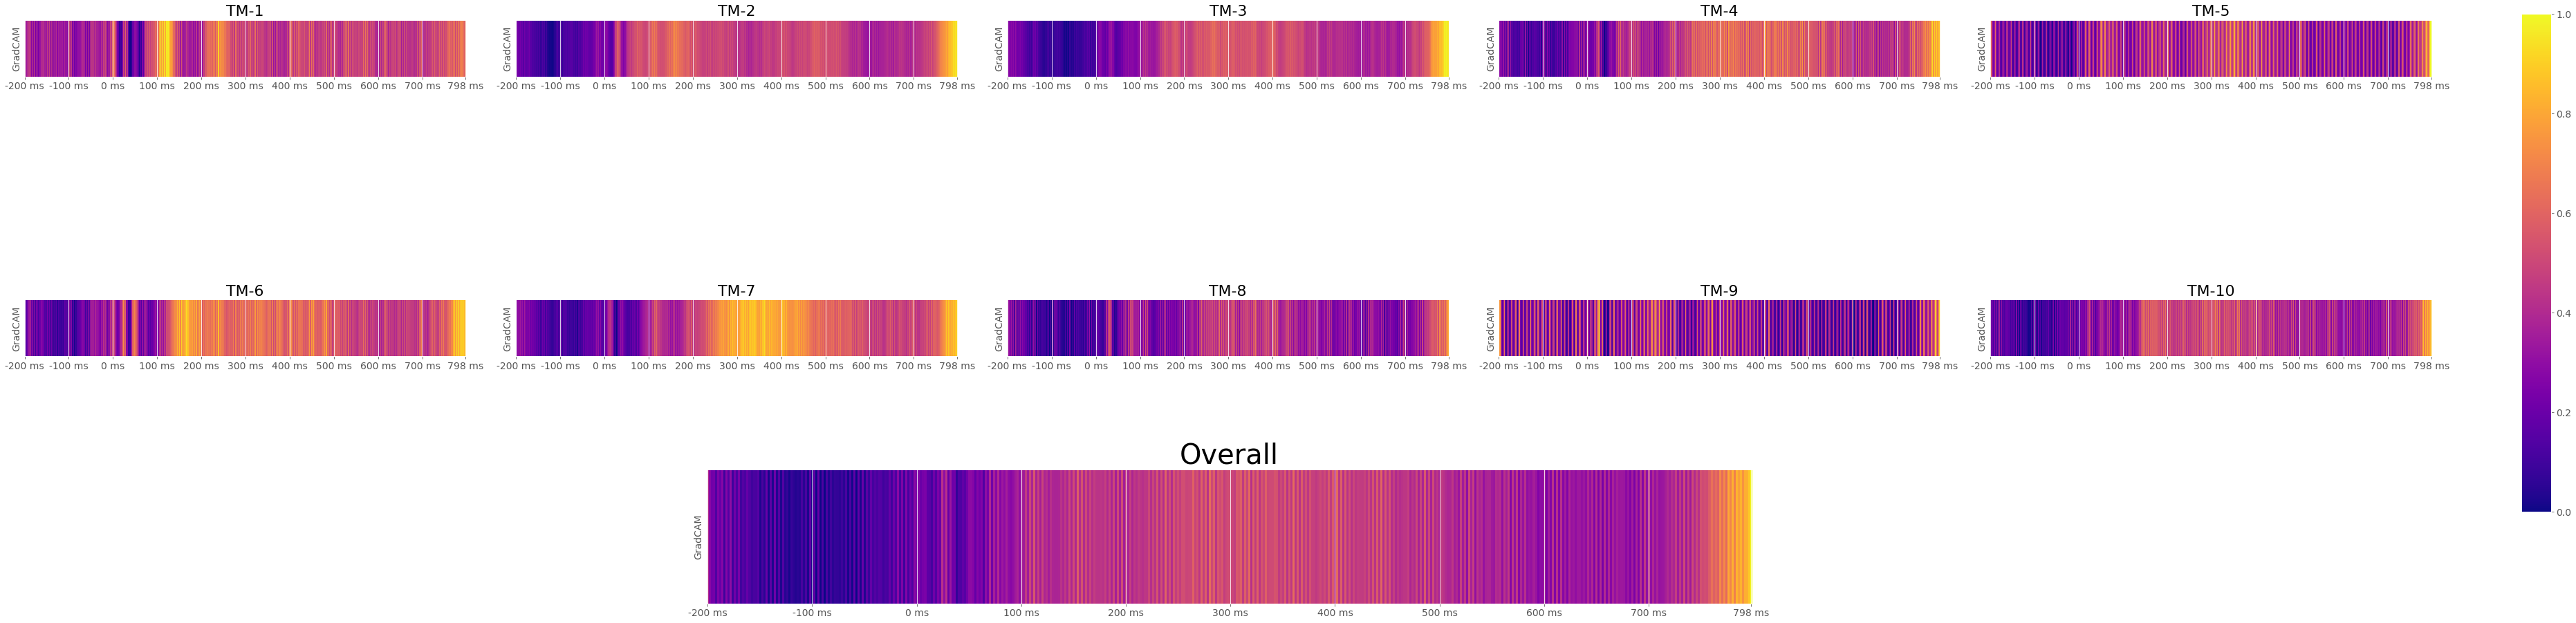

In [16]:
T = np.linspace(-200, 798, 500, dtype=np.int)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(60,20), constrained_layout=False)

axes = axes.flatten()

for i,id in enumerate(model_ids):
    viz_avg_smaps(model_smaps[id].transpose(), T, id, axes[i])
    
fig.tight_layout(pad=1.5)

fig.subplots_adjust(bottom=0.1)
ax = fig.add_axes([0.2425, -0.10, 0.35, 0.45])
viz_avg_smaps(normalize(np.mean(overall_tm_smaps, axis=0)).transpose(), T, 'Overall', ax)
ax.set_title('Overall', fontdict={'size':40})
fig.subplots_adjust(right=0.82, top=0.85)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.5])

cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm,
                                orientation='vertical', ticklocation='right')


plt.show()

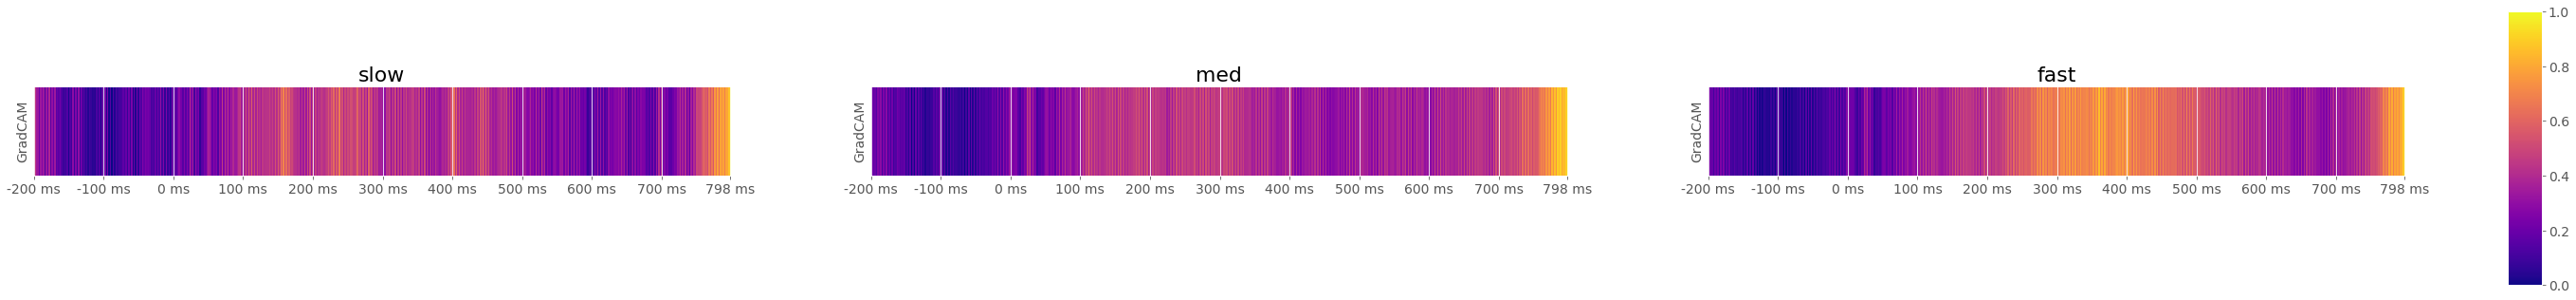

In [17]:
slow_i_range = [0, n_slow]
med_i_range = [n_slow, n_slow + n_med]
fast_i_range = [n_slow + n_med, n_slow + n_med + n_fast]

slow = overall_tm_smaps[:slow_i_range[1]]
med = overall_tm_smaps[med_i_range[0]: med_i_range[1]]
fast = overall_tm_smaps[fast_i_range[0]: fast_i_range[1]]

smaps = [slow, med, fast]

fig, axes = plt.subplots(ncols=3, figsize=(50,20))

axes = axes.flatten()

rt_class = ['slow', 'med', 'fast']

for i, sm in enumerate(smaps):
    viz_avg_smaps(normalize(np.mean(sm, axis=0)).transpose(), T, rt_class[i], axes[i])
    
fig.subplots_adjust(right=0.82, top=0.5)
cbar_ax = fig.add_axes([0.85, 0.2, 0.01, 0.2])

cmap = mpl.cm.plasma
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm,
                                orientation='vertical', ticklocation='right')


plt.show()

In [19]:
model_sc = dict()
for i,id in tqdm(enumerate(model_ids)):
    model_sc_rt = dict()
    for cls in rt_class:
        model_sc_rt[cls] = np.load("saliency_scores/median/{}/{}.npy".format(cls, id))
    
    model_sc[id] = scale_sc(model_sc_rt)
    
overall_tm_sc = get_overall_sc(model_sc, acc_dict)

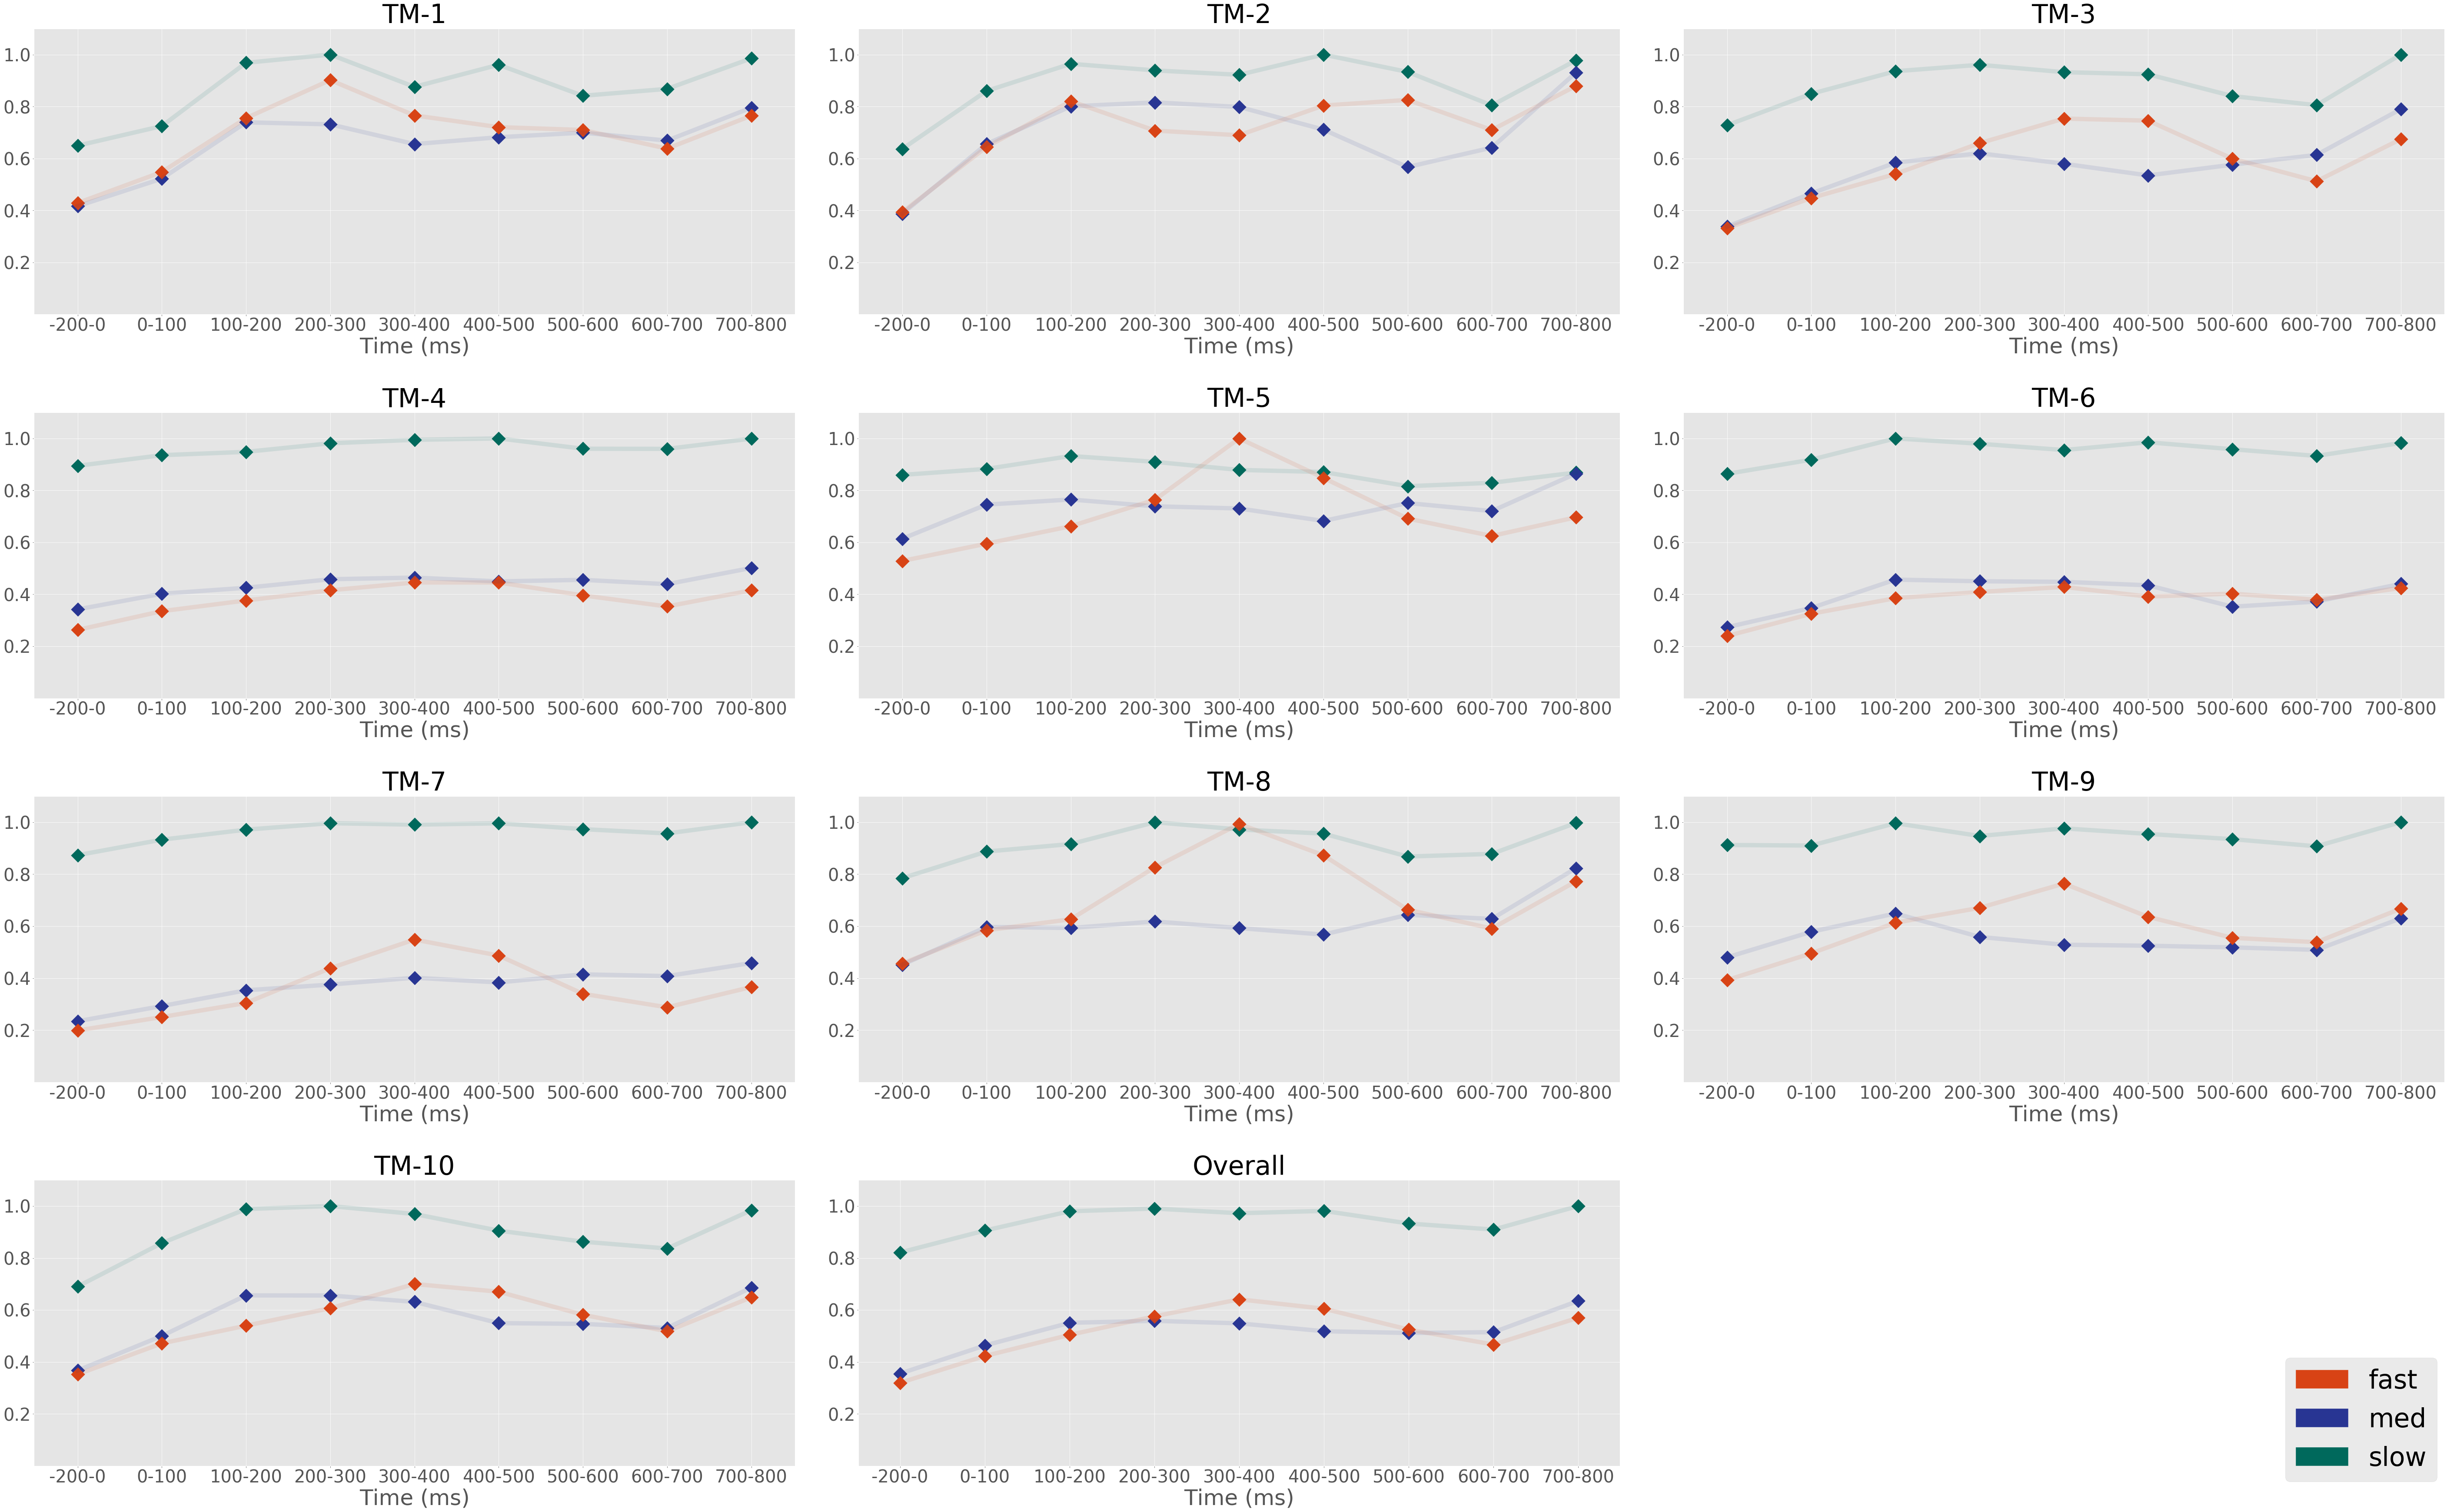

In [103]:
fig = plt.figure(figsize=(80,50))
gs = gridspec.GridSpec(4, 3, width_ratios=[2,2,2])

plt.rc('axes', titlesize=60)     # fontsize of the axes title
plt.rc('axes', labelsize=50)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=40)    # fontsize of the tick labels
plt.rc('ytick', labelsize=40)    # fontsize of the tick labels
plt.rc('legend', fontsize=60)

for i,id in enumerate(model_ids):
    viz_temporal_saliency(model_sc[id], T, id, rt_class, gs[i])
    
fig.tight_layout(pad=2.5)



viz_temporal_saliency(overall_tm_sc, T, 'Overall', rt_class, gs[-1, 1])

slow_patch = mpatches.Patch(color="#00695C", label='slow')
med_patch = mpatches.Patch(color="#283593", label='med')
fast_patch = mpatches.Patch(color="#D84315", label='fast')

fig.legend(handles=[fast_patch, med_patch, slow_patch], loc=(0.93,0.02))

plt.show()

In [17]:
overall_tm_sc['slow'][1]

array([0.10288392, 0.04411044, 0.07578357, 0.0501098 , 0.05659366,
       0.10465375, 0.06515301, 0.065458  , 0.16116668])

## Store Temporal Saliency for ANOVA

In [18]:
time_ticks = np.arange(0,9,1)
time_labels = ['Pre-stimulus']
time_labels.extend(['{}-{} ms'.format(T[i], T[i+50]) for i in range(100, 500, 50) if i + 50 < 500])
time_labels.append('700-800 ms')

slow = overall_tm_sc['slow']
med = overall_tm_sc['med']
fast = overall_tm_sc['fast']

slow_g = np.array(n_slow * ['slow']).reshape((-1, 1))
med_g = np.array(n_med * ['med']).reshape((-1, 1))
fast_g = np.array(n_fast * ['fast']).reshape((-1, 1))

data = np.vstack((slow, med, fast))
groups = np.vstack((slow_g, med_g, fast_g))
subjects = pd.read_csv("data/sub_test_10.csv")

df = pd.DataFrame(data)

df.insert(0, 'group', groups)
df.insert(1, 'subs', subjects['subs'])


columns = ['group', 'subs']
columns.extend(time_labels)
df.columns = columns

df_melt = pd.melt(df, id_vars=['group', 'subs'], value_vars=time_labels)
df_melt.columns = ['groups', 'subs', 'timesteps', 'saliency']
df_melt.to_csv("ANOVA/Overall_Temporal_Saliency.csv")
# df_anova = df_melt.groupby(['subs', 'timesteps', 'groups']).mean().reset_index()
# df_anova.mean()

In [19]:
df_melt

,groups,subs,timesteps,saliency
0,slow,S20,Pre-stimulus,0.026308
1,slow,T8,Pre-stimulus,0.102884
2,slow,N9,Pre-stimulus,0.079823
3,slow,N6,Pre-stimulus,0.026637
4,slow,N11,Pre-stimulus,0.349829
...,...,...,...,...
166504,fast,T12,700-800 ms,0.054074
166505,fast,S12,700-800 ms,0.029712
166506,fast,S8,700-800 ms,0.011540
166507,fast,N3,700-800 ms,0.201100


In [20]:
all_temporal_scs = np.vstack((model_sc['TM-1']['slow'], model_sc['TM-1']['med'], model_sc['TM-1']['fast'])) 
subs = subjects['subs']
model_ids = np.array(len(all_temporal_scs) * ['TM-1'])
for i,id in tqdm(enumerate(model_sc)):
    if i == 0:
        continue
    temporal_scs = np.vstack((model_sc[id]['slow'], model_sc[id]['med'], model_sc[id]['fast']))
    all_temporal_scs = np.vstack((all_temporal_scs, temporal_scs))
    
    slow_g = np.array(n_slow * ['slow']).reshape((-1, 1))
    med_g = np.array(n_med * ['med']).reshape((-1, 1))
    fast_g = np.array(n_fast * ['fast']).reshape((-1, 1))
    
    groups = np.vstack((groups, slow_g, med_g, fast_g))
    
    model_ids = np.append(model_ids, len(temporal_scs) * [id])
    
    subs = np.append(subs, subjects['subs'])
    
data_temporal_sm = pd.DataFrame(all_temporal_scs, columns=time_labels)

data_temporal_sm.insert(0, 'group', groups)
data_temporal_sm.insert(1, 'subs', subs.reshape((-1, 1)))
data_temporal_sm.insert(2, 'model', model_ids.reshape((-1,1)))

columns = ['group', 'subs', 'model']
columns.extend(time_labels)
data_temporal_sm.columns = columns

df_melt = pd.melt(data_temporal_sm, id_vars=['group', 'subs', 'model'], value_vars=time_labels)
df_melt.columns = ['groups', 'subs', 'model', 'timesteps', 'saliency']
df_melt.to_csv("ANOVA/temporal_Saliency_all_TMs.csv")
df_melt



,groups,subs,model,timesteps,saliency
0,slow,S20,TM-1,Pre-stimulus,0.000000
1,slow,T8,TM-1,Pre-stimulus,0.000000
2,slow,N9,TM-1,Pre-stimulus,0.084798
3,slow,N6,TM-1,Pre-stimulus,0.132356
4,slow,N11,TM-1,Pre-stimulus,0.005097
...,...,...,...,...,...
1665085,fast,T12,TM-10,700-800 ms,0.000000
1665086,fast,S12,TM-10,700-800 ms,0.065590
1665087,fast,S8,TM-10,700-800 ms,0.000000
1665088,fast,N3,TM-10,700-800 ms,0.141041


In [178]:
np.exp(data).min()

1.0